In [35]:
import os
import sys

PATHNAME = "/content/drive/MyDrive"
if not os.path.exists(PATHNAME):
    PATHNAME = os.getcwd()

print(PATHNAME)
DATA_FOLDER = os.path.join(PATHNAME, "dataset")
OUTPUT_DIR = os.path.join(PATHNAME, "output")

/home/akshat/dip_project/DIP_Project


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

from IPython.display import Video

## Opening the Video file and Pre-processing

In [37]:
def saveFramesToVideo(frames, savepath, fps=1):
  num_frames, H, W, C = frames.shape
  video = cv2.VideoWriter(savepath, 0, fps, (W, H))

  for frame in frames:
    video.write(frame)
  cv2.destroyAllWindows()
  print(f"Saving video to {savepath}")
  video.release()

Path of video file: /home/akshat/dip_project/DIP_Project/dataset/bobble_small.mp4
(160, 416, 336)
Number of frames = 160


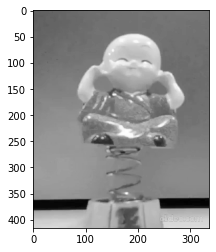

In [38]:
video_file_name = "bobble_small.mp4"
video_path = os.path.join(DATA_FOLDER, video_file_name)

if os.path.exists(video_path):
    print(f"Path of video file: {video_path}")

# reading the video file
video_capture = cv2.VideoCapture(video_path)
num_frames = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
fps = video_capture.get(cv2.CAP_PROP_FPS)

frames = []
check = True
count = 0
initial_frame = None

while check:
    check, arr = video_capture.read()
    if arr is not None:
      if count == 0:
        initial_frame = np.copy(arr)
      arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
      frames.append(arr)
      count += 1

frames = np.array(frames)
print(frames.shape)
num_frames = frames.shape[0]
print(f"Number of frames = {num_frames}")

plt.imshow(frames[0], cmap='gray')


## Calculating Flow and Displacement of the entire video

In [39]:
def calcVideoFlow(frames):
  """
  Calculates the flow of a video

  Input:
    - frames : grayscale image array of shape (num_frames, H, W)

  Output:
    - flows : flow array of shape (num_frames, H, W, 2)
  """
  num_frames = frames.shape[0]
  flows = []
  for i in range(1, num_frames):
    flow = cv2.calcOpticalFlowFarneback(
        frames[i - 1], frames[i], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flows.append(flow)

  flows = np.array(flows) # shape = (num_frames, H, W, 2)
  return flows

def convertFlowToRGB(flows):
  """
  converts the flow to RGB
  """
  num_frames, H, W, C = flows.shape
  hsv = np.zeros((num_frames, H, W, 3), dtype=np.uint8)
  flows_rgb = np.empty_like(hsv)
  hsv[:, :, :, 1] = 255 # setting the saturation to 255
  #hsv[:, :, :, 0] = 255

  for i in range(num_frames):
    # Set the hue and value according to the angle and magnitude
    magnitude, angle = cv2.cartToPolar(flows[i, :, :, 0], flows[i, :, :, 1])
    hsv[i, :, :, 0] = (angle * 180)/(2 * np.pi)
    hsv[i, :, :, 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flows_rgb[i] = cv2.cvtColor(hsv[i], cv2.COLOR_HSV2BGR)

  return flows_rgb

def calcDispFromFlow(flows):
  """
  Get the displacement values from flow

  Input:
    - flows : array of shape (num_frames, H, W, 2) containing flow in x and y directions

  Output:
    - disp: array of shape (num_frames, H, W, 2) containing displacement in x and y directions
  """
  num_frames, H, W, _ = flows.shape
  disp = np.zeros((num_frames, H, W, 2), dtype=flows.dtype)
  disp[0] = flows[0]

  # adding flow values along x and y directions
  for i in range(1, num_frames):
    disp[i] += disp[i - 1] + flows[i]
  # disp[1:, :, :, 0] = np.cumsum(flows[:, :, :, 0], axis=-1)
  # disp[1:, :, :, 1] = np.cumsum(flows[:, :, :, 1], axis=-1)

  return disp

In [40]:
# calculating the flow of every frame in the entire video
flows = calcVideoFlow(frames)
print(flows.shape)

(159, 416, 336, 2)


In [41]:
# calculating the displacement from the flow values of the entire video
disp = calcDispFromFlow(flows) # (num_frames, H, W, 2)
print(disp.shape)

(159, 416, 336, 2)


In [42]:
# plt.plot(disp[:, pixel[0], pixel[1], 1])

In [43]:
# converting the flow to RGB format for visualization purposes
flows_rgb = convertFlowToRGB(flows)
print(flows_rgb.shape)

(159, 416, 336, 3)


## Converting Flow to Flow RGB for visualization

In [44]:
# convert the flow to RGB for visualization purposes
flows_rgb = convertFlowToRGB(flows)
print(flows_rgb.shape)

(159, 416, 336, 3)


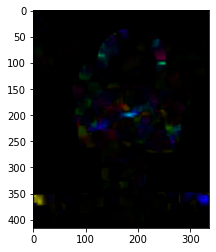

In [45]:
plt.imshow(flows_rgb[1])

In [46]:
# saving the flow rgb video
savepath = os.path.join(OUTPUT_DIR, "flow-rgb.avi")

saveFramesToVideo(flows_rgb, savepath, fps)

Saving video to /home/akshat/dip_project/DIP_Project/output/flow-rgb.avi


In [47]:
#Video(savepath, embed=True)

## Calculating FFT of displacement

In [48]:
def calcPixelSpectrum(disp, pixel, axis=0):
  """
  Calculates the frequency spectrum of a pixel of a displacement values along an axis
  axis 0 = displacement in x direction
  axis 1 = displacement in y direction
  """
  num_frames, H, W, C = disp.shape
  i, j = pixel
  pixel_disp = disp[:, i, j, axis] # shape: (num_frames, )
  pixel_disp = pixel_disp - np.mean(pixel_disp)

  fft_result = np.fft.fft(pixel_disp)
  frequencies = np.fft.fftfreq(num_frames)
  magnitude = np.abs(fft_result)

  return frequencies, magnitude

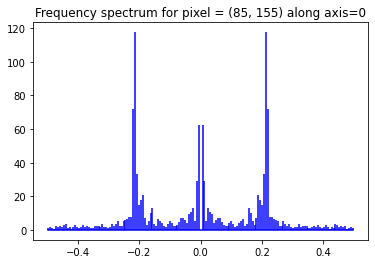

Index of max frequency = 125, max frequency = -0.2138364779874214


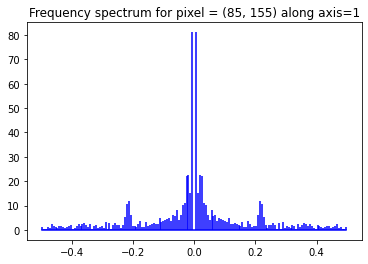

Index of max frequency = 158, max frequency = -0.006289308176100629


In [49]:
# plotting the displacement frequency spectrum for a particular pixel in the image
pixel = (85, 155)

axisX = 0
axisY = 1
frequenciesX, magnitudeX = calcPixelSpectrum(disp, pixel, axisX)
frequenciesY, magnitudeY = calcPixelSpectrum(disp, pixel, axisY)

plt.stem(frequenciesX, magnitudeX, 'b', markerfmt=" ", basefmt="-b")
plt.title(f"Frequency spectrum for pixel = {pixel} along axis={axisX}")
plt.show()

plt.stem(frequenciesY, magnitudeY, 'b', markerfmt=" ", basefmt="-b")
plt.title(f"Frequency spectrum for pixel = {pixel} along axis={axisY}")

max_freq_indexX = np.argsort(magnitudeX)[::-1][0]
max_freqX = frequenciesX[max_freq_indexX]
print(f"Index of max frequency = {max_freq_indexX}, max frequency = {max_freqX}")
plt.show()

max_freq_indexY = np.argsort(magnitudeY)[::-1][0]
max_freqY = frequenciesY[max_freq_indexY]
print(f"Index of max frequency = {max_freq_indexY}, max frequency = {max_freqY}")
plt.show()



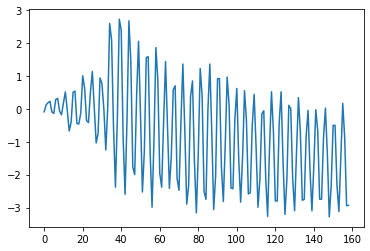

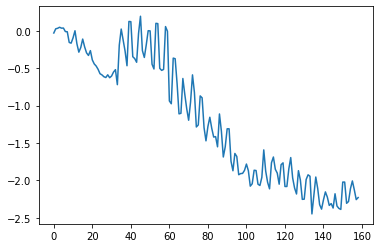

In [50]:
plt.plot(disp[:, pixel[0], pixel[1], 0])
plt.show()
plt.plot(disp[:, pixel[0], pixel[1], 1])

## Calculating Power Spectrum of image

In [51]:
def calcPowerSpectrum(disp, axis=0):
  num_frames, H, W, C = disp.shape
  magnitude_sums = np.zeros(num_frames)

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0)

  mean_magnitudes = np.mean(np.abs(fft_result), axis=1)
  return fft_frequencies, mean_magnitudes

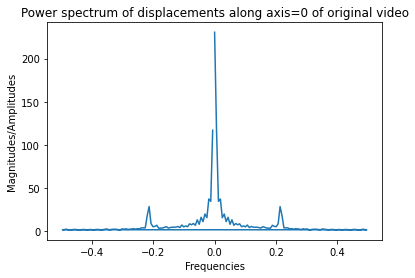

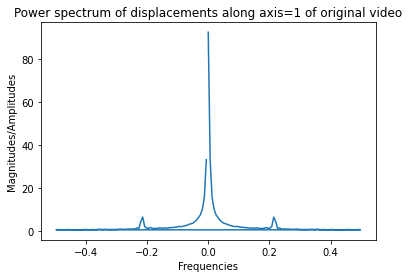

In [52]:
axis = 0
fft_frequenciesX, mean_magnitudesX = calcPowerSpectrum(disp, axisX)
fft_frequenciesY, mean_magnitudesY = calcPowerSpectrum(disp, axisY)

plt.title(f"Power spectrum of displacements along axis={axisX} of original video")
plt.xlabel("Frequencies")
plt.ylabel("Magnitudes/Amplitudes")
plt.plot(fft_frequenciesX, mean_magnitudesX)

plt.show()

plt.title(f"Power spectrum of displacements along axis={axisY} of original video")
plt.xlabel("Frequencies")
plt.ylabel("Magnitudes/Amplitudes")
plt.plot(fft_frequenciesY, mean_magnitudesY)

plt.show()

## Showing Mode Shapes

In [53]:
def calcFreqShape(disp, axis=0, freq_index=0):
  """
  Calculating amplitude of a particular frequency of
  displacement in a set direction for all the pixels

  axis 0 = displacement in x direction
  axis 1 = displacement in y direction
  """
  num_frames, H, W, C = disp.shape

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0) # shape: (num_frames, H*W)

  magnitude, angle = np.abs(fft_result), np.angle(fft_result)
  magnitude = np.squeeze(magnitude[freq_index]).reshape(H, W)
  return fft_result[freq_index]

def calcModeShape(disp, axis=0, freq_index=0):
  num_frames, H, W, C = disp.shape
  mode_shape = np.zeros((H, W, 3), dtype=np.uint8)

  mode_shape[:, :, 0] = 255
  mode_shape[:, :, 1] = 255

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0) # shape: (num_frames, H*W)

  magnitude, angle = np.abs(fft_result), np.angle(fft_result)
  magnitude = magnitude.reshape(num_frames, H, W)
  angle = angle.reshape(num_frames, H, W)

  mode_shape[:, :, 0] = angle[freq_index]
  mode_shape[:, :, 2] = magnitude[freq_index]

  mode_shape[:, :, 2] = cv2.normalize(mode_shape[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
  mode_shape = cv2.cvtColor(mode_shape, cv2.COLOR_HSV2BGR)

  return mode_shape

In [54]:
# calculating the mode shape
freq_indexX = max_freq_indexX
freq_indexY = max_freq_indexY
mode_shapeX = calcModeShape(disp, axisX, freq_indexX)
mode_shapeY = calcModeShape(disp, axisY, freq_indexY)

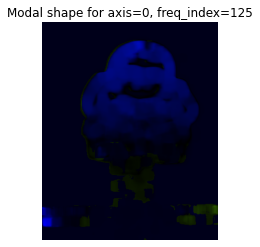

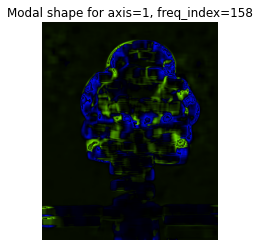

In [55]:
# displaying the mode shape for a particular frequency
plt.title(f"Modal shape for axis={axisX}, freq_index={freq_indexX}")
plt.axis("off")
plt.imshow(mode_shapeX)

plt.show()

# displaying the mode shape for a particular frequency
plt.title(f"Modal shape for axis={axisY}, freq_index={freq_indexY}")
plt.axis("off")
plt.imshow(mode_shapeY)

plt.show()

## Implementing Physics of Modal analysis

In [56]:
best_modeX = calcFreqShape(disp, axis=axisX, freq_index=max_freq_indexX)
best_modeX = best_modeX.reshape(-1)
print(best_modeX.shape)

best_modeY = calcFreqShape(disp, axis=axisY, freq_index=max_freq_indexY)
best_modeY = best_modeY.reshape(-1)
print(best_modeY.shape)

(139776,)
(139776,)


In [61]:
def calcDisplacment(hyp, freq, pixel, force, best_modeX, best_modeY):
    '''
    hyp is the dictionary having the hyperparameters
    freq is the user defined frequency of the mode shape
    pixel is the point of application of force
    force is the 2D vector correponding to the force applied by the user
    '''
    alpha = hyp['amplification'] # Amplification factor
    # The force in the modal coordinates
    f_x = alpha * force[0] * np.abs(best_modeX[pixel[0] * hyp["width"] + pixel[1]])
    f_y = alpha * force[1] * np.abs(best_modeY[pixel[0] * hyp["width"] + pixel[1]])

    t = hyp["time"] # The total time of the simulation
    x = np.zeros((t + 1, 2)) # The array corresponding to the output displacement in the x dirn
    y = np.zeros((t + 1, 2)) # The array corresponding to the output displacement in the y dirn
    dt = 1 # we had assumed time stamp is 1 in the x+vt
    d = hyp["damp"] # damping factor
    m = hyp["mass"]
    
    freqX, freqY = freq

    for i in range(t):
        # m1 = np.array([[1, h], [-w**2 * h, 1 - 2*d*w*h]])
        # m2 = np.array([0, h/m])
        # Numerically unstable code

        # if(i != 0):
        #   f = 0
        # y[i + 1] = (m1 @ y[i].T)
        # y[i + 1] = y[i + 1].T
            
        # if(i):
        # Numerically Stable Formula
        x[i + 1, 0] = (f_x / (freqX * m)) * (np.e ** (- d * freqX * i * dt)) * np.sin(freqX * i * dt) # The actual displacement
        y[i + 1, 0] = (f_y / (freqY * m)) * (np.e ** (- d * freqY * i * dt)) * np.sin(freqY * i * dt) # The actual displacement
        x[i + 1, 1] = (x[i + 1, 0] - x[i, 0]) / dt
        y[i + 1, 1] = (y[i + 1, 0] - y[i, 0]) / dt

    return x, y


In [59]:
max_freqY

-0.006289308176100629

(416, 336)


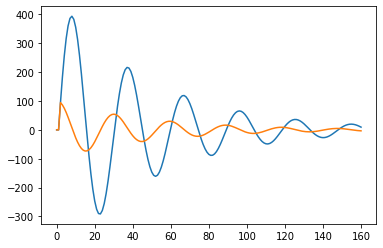

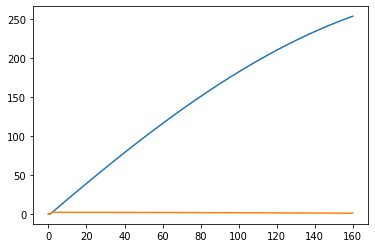

In [62]:
hyp = {'amplification' : 1, 'time' : 160, 'mass' : 1, 'damp' : 0.095, 'width': frames[0].shape[1], 'sample' : 1}
print(frames[0].shape)
freq = (abs(max_freqX), abs(max_freqY))
force = [1, 0.03]
x, y = calcDisplacment(hyp, freq, pixel, force, best_modeX, best_modeY)

plt.plot(x)
plt.show()
plt.plot(y)
plt.show()

In [27]:
best_modeX.shape

(407040,)

### Finding Phi (modal matrix)

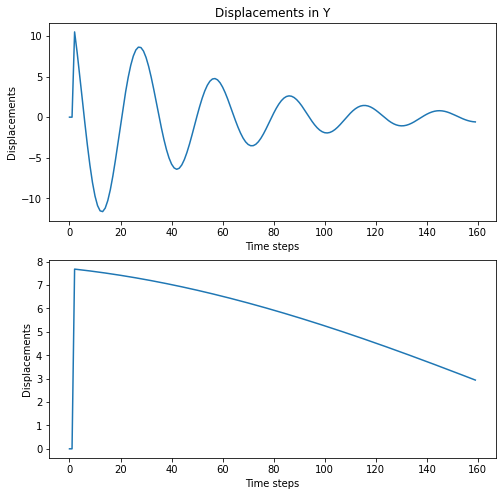

In [69]:
num_frames, H, W = frames.shape
final_displacement = np.zeros((hyp['time'], H * W, 2))

for i in range(hyp['time']):
  q = np.complex128(x[i, 0] + (x[i, 1] / max_freqX) * 1j )
  final_displacement[i, :, 0] = (q * best_modeX).real
  
  q = np.complex128(y[i, 0] + (y[i, 1] / max_freqY) * 1j )
  final_displacement[i, :, 1] = (q * best_modeY).real


# Plotting the final displacements of the pixel whose best mode was chosen
p2 = pixel

final_displacement = final_displacement / 3000
# displacements_norm = final_displacement[:, p2[0] * W + p2[1]]

displacementsX = final_displacement[:, p2[0] * W + p2[1], 0]
displacementsY = final_displacement[:, p2[0] * W + p2[1], 1]

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs = axs.flatten()

axs[0].set_title("Displacements in X")
axs[0].set_xlabel("Time steps")
axs[0].set_ylabel("Displacements")
axs[0].plot(displacementsX)


axs[0].set_title("Displacements in Y")
axs[1].set_xlabel("Time steps")
axs[1].set_ylabel("Displacements")
axs[1].plot(displacementsY)

plt.show()

## Rendering the simulation

In [70]:
# applying force along x direction
T = 200 # number of time-steps to simulate for
H, W, C = initial_frame.shape
final_displacement = final_displacement.reshape(-1, H, W) # (num_frames, H, W)
limit = W if dir == 1 else H # limit of the final destination

inpainting_mask = np.zeros((H, W), dtype=np.uint8)

# initialize the current frame with the initial frame
cur_frame = np.copy(initial_frame)
output_frames = []
output_frames.append(cur_frame)

grid = np.indices((H, W)) # shape = (2, H, W)

# Loop through each time-step/frame
for frame_idx in range(T):
  # calculating final destination of each pixel from the displacement values
  frame_flow_data = final_displacement[frame_idx] # shape = (H, W)
  final_destination = (grid[1] + frame_flow_data).astype(np.int64) # shape = (H, W)

  # indices of all valid new x positions
  indices = (0 <= final_destination) & (final_destination < limit)

  # apply optical flow for all the valid indices
  y, x = grid[0][indices], grid[1][indices]
  new_x = final_destination[indices]
  cur_frame[y, new_x] = initial_frame[y, x]
#   fig, ax = plt.subplots(1, 2)
#   plt.suptitle(str(frame_idx))
#   ax[0].imshow(cur_frame)
#   ax.show()

  # mark all the other pixels for inpainting
  inpainting_mask[grid[0][~indices], grid[1][~indices]] = 255 # set to white
#   cur_frame[grid[0][~indices], grid[1][~indices]] = 255 # set to white
  # performing inpainting on the current frame to fill gaps
  inpainting_radius = 5
  cur_frame = cv2.inpaint(cur_frame, inpainting_mask, inpainting_radius, cv2.INPAINT_TELEA)
#   ax[1].imshow(cur_frame)
#   plt.show()

  output_frames.append(cur_frame)

output_frames = np.array(output_frames)

IndexError: index 337 is out of bounds for axis 1 with size 336

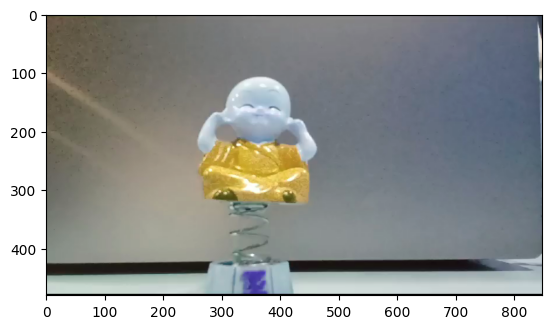

In [ ]:
plt.imshow(output_frames[1], cmap="gray")

In [ ]:
# saving the output frames
print(output_frames.shape)
savepath = os.path.join(OUTPUT_DIR, "output1.avi")

saveFramesToVideo(output_frames, savepath, fps)

(501, 480, 848, 3)
Saving video to /Users/shreyu/Workspace/IIIT/3-1/DIP/project/DIP_Project/output/output1.avi


#### Experimenting

In [ ]:
# applying force along x direction
T = 500 # number of time-steps to simulate for
H, W, C = initial_frame.shape
final_displacement = final_displacement.reshape(-1, H, W) # (num_frames, H, W)
limit = W if dir == 1 else H # limit of the final destination

inpainting_mask = np.zeros((T, H, W), dtype=np.uint8)

# initialize the current frame with the initial frame
frame_repeated = np.repeat(initial_frame[np.newaxis, :, :], T, axis=0) # shape (T, H, W)

output_frames = np.zeros((T + 1, H, W, C), dtype=initial_frame.dtype)
output_frames[0] = np.copy(initial_frame)

grid = np.indices((H, W)) # shape = (2, H, W)

y = np.repeat(grid[np.newaxis, :, :], T, axis=0) # shape (T, H, W)
x = np.repeat(grid[np.newaxis, :, :], T, axis=0) # shape (T, H, W)
final_destination = (x + final_displacement[:T]).astype(np.int64) # shape = (T, H, W)

# indices of all valid new x positions
indices = (0 <= final_destination) & (final_destination < limit) # shape (T, H, W)

# apply optical flow for all the valid indices
valid_y, valid_x = y[indices], x[indices] # shape (T, H, W)
new_x = final_destination[indices] # shape (T, H, W)
output_frames[1:, valid_y, new_x] = frame_repeated[valid_y, valid_x]

# mark all the invalid pixels for inpainting
inpainting_mask[~indices] = 255

# performing inpainint on all the frames to fill the gaps
inpainting_radius = 5
for frame_idx in range(1, T):
  output_frames[frame_idx] = cv2.inpaint(
      output_frames[frame_idx], inpainting_mask[indices],
      inpainting_radius, cv2.INPAINT_TELEA)

output_frames = np.array(output_frames)

ValueError: operands could not be broadcast together with shapes (500,2,480,848) (500,480,848) 